In [1]:
from autocvd import autocvd
autocvd(num_gpus = 1)


import optimistix as optx
import jax

import jax.numpy as jnp
from jax import vmap, jit
import jax.random as random


import matplotlib.pyplot as plt

import odisseo
from odisseo import construct_initial_state
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX, DIRECT_ACC_LAXMAP
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, NFW_POTENTIAL, PlummerParams, MN_POTENTIAL, LogarithmicParams, LOGARITHMIC_POTENTIAL
from odisseo.initial_condition import Plummer_sphere
from odisseo.units import CodeUnits

from astropy import units as u

code_length = 10.0 * u.kpc
code_mass = 1e5 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [2]:
config = SimulationConfig(N_particles=1_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=10_000, 
                          external_accelerations=(), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening=(1 * u.pc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(4.5*1e4 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=1000, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=10000, softening=np.float64(0.00010000000000000002), integrator=0, diffrax_solver=0, acceleration_scheme=2, batch_size=10000, double_map=False, external_accelerations=(), differentation_mode=1, diffrax_adjoint_method=0, num_checkpoints=100, progress_bar=False, gradient_horizon=0)
SimulationParams(G=1, t_end=np.float64(0.21209672678920705), Plummer_params=PlummerParams(a=np.float64(0.0008000000000000001), Mtot=np.float64(0.44999999999999996)), NFW_params=NFWParams(Mvir=162000000000.0, r_s=15.3), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28), PSP_params=PSPParams(M=4501365375.06545, alpha=1.8, r_c=1.9), Logarithmic_params=LogarithmicParams(v0=220.0, q=0.9))


(-50.0, 50.0)

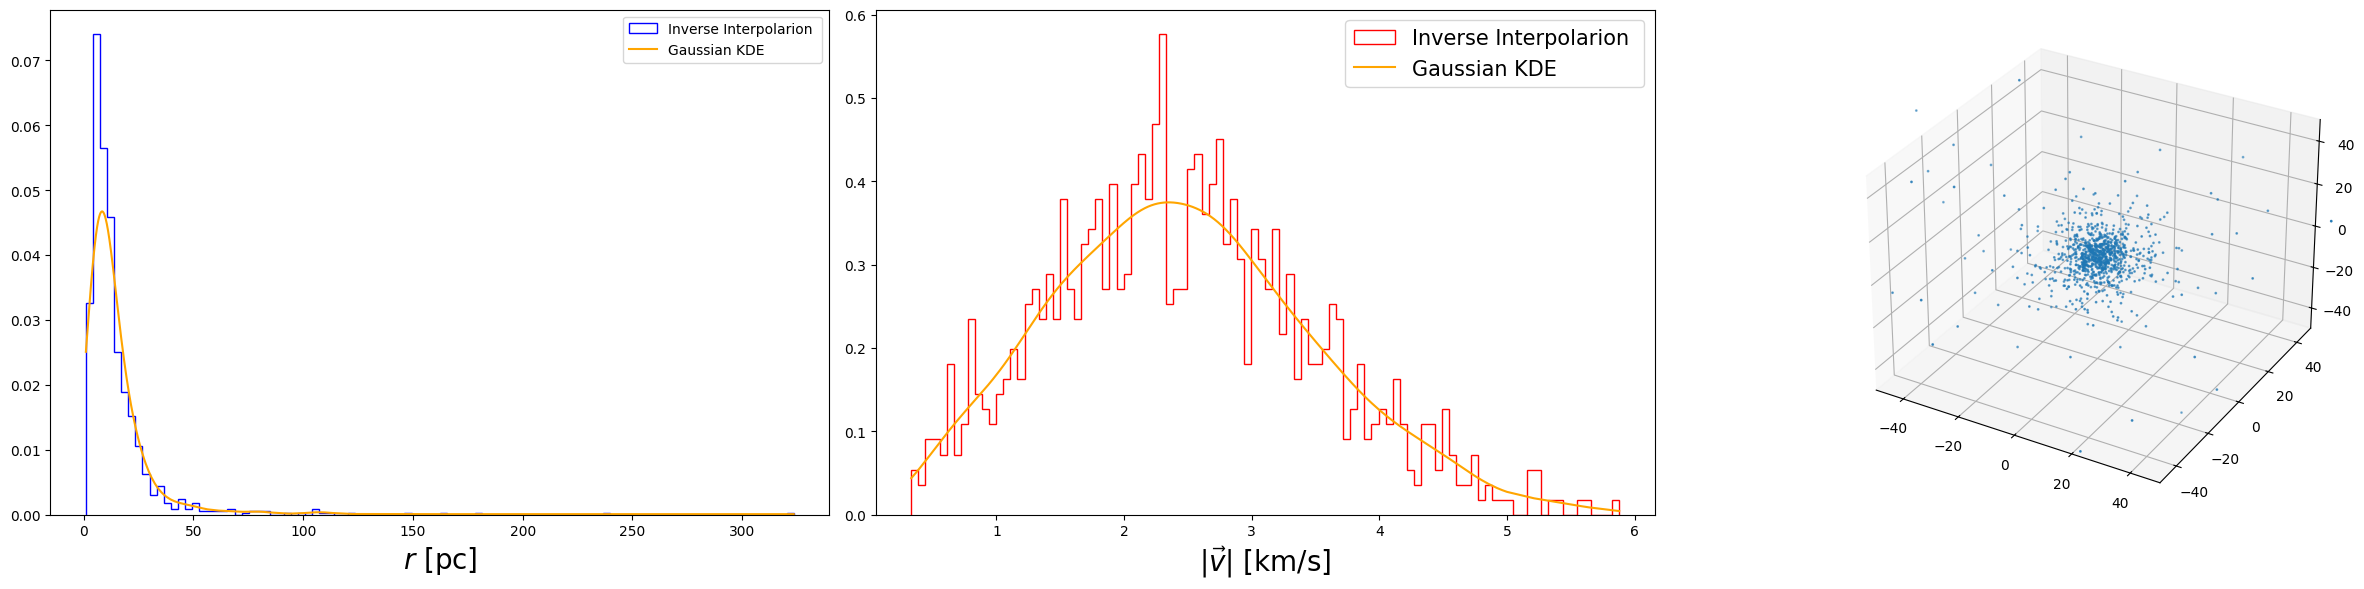

In [3]:
from jax.scipy.stats import gaussian_kde

positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
fig = plt.figure(figsize=(25, 6), tight_layout=True)
ax = fig.add_subplot(131)
r = jnp.linalg.norm(positions, axis=1)*code_units.code_length.to(u.pc)
r_gaussian_kde = gaussian_kde(r).pdf(r.sort())
ax.hist(r, bins=100, color='b', histtype='step', label='Inverse Interpolarion ', density=True)
plt.plot(r.sort(), r_gaussian_kde, color='orange', label='Gaussian KDE')
ax.set_xlabel('$r$ [pc]', fontsize=20)
ax.legend()

vel = jnp.linalg.norm(velocities, axis=1)*code_units.code_velocity.to(u.km/u.s)
vel_gaussian_kde = gaussian_kde(vel).pdf(vel.sort())
ax = fig.add_subplot(132)
ax.hist(vel, bins=100, color='r', histtype='step', label='Inverse Interpolarion ', density=True)
plt.plot(vel.sort(), vel_gaussian_kde, color='orange', label='Gaussian KDE')
ax.legend(fontsize=15)
ax.set_xlabel(r'$|\vec{v}|$ [km/s]', fontsize=20)

ax = fig.add_subplot(133, projection='3d')
ax.scatter(positions[:,0]*code_units.code_length.to(u.pc), positions[:,1]*code_units.code_length.to(u.pc), positions[:,2]*code_units.code_length.to(u.pc), s=1)
# ax.set_xlabel('x [pc]', fontsize=15)
# ax.set_ylabel('y [pc]', fontsize=15)
# ax.set_zlabel('z [pc]', fontsize=15)
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_zlim(-50, 50)



In [4]:
from jax.scipy.special import  kl_div
# r_support = jnp.linspace(0.01, 50, 1000)
# v_support = jnp.linspace(0.000, 6, 1000)
r_support = r.sort()
v_support = vel.sort()

r_kde_target = gaussian_kde(r).pdf(r_support)
v_kde_target = gaussian_kde(vel).pdf(v_support)

@jit
def loss_initial_condition(p, ):
    params_sim = params._replace(Plummer_params=PlummerParams(Mtot=p['Mtot'],
                                                        a=p['a'],))
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(42), params=params_sim, config=config)
    r_sim = jnp.linalg.norm(positions, axis=1) * code_units.code_length.to(u.pc)
    vel_sim = jnp.linalg.norm(velocities, axis=1) * code_units.code_velocity.to(u.km/u.s)


    r_kde_sim = gaussian_kde(r_sim).pdf(r_support)
    v_kde_sim = gaussian_kde(vel_sim).pdf(v_support)

    loss =  kl_div(v_kde_sim, v_kde_target).sum() + kl_div(r_kde_sim, r_kde_target).sum()

    return loss 

loss = loss_initial_condition({'Mtot':5e4, 'a':8.0})


Text(0, 0.5, '$\\nabla_{a_{P}}$ Loss')

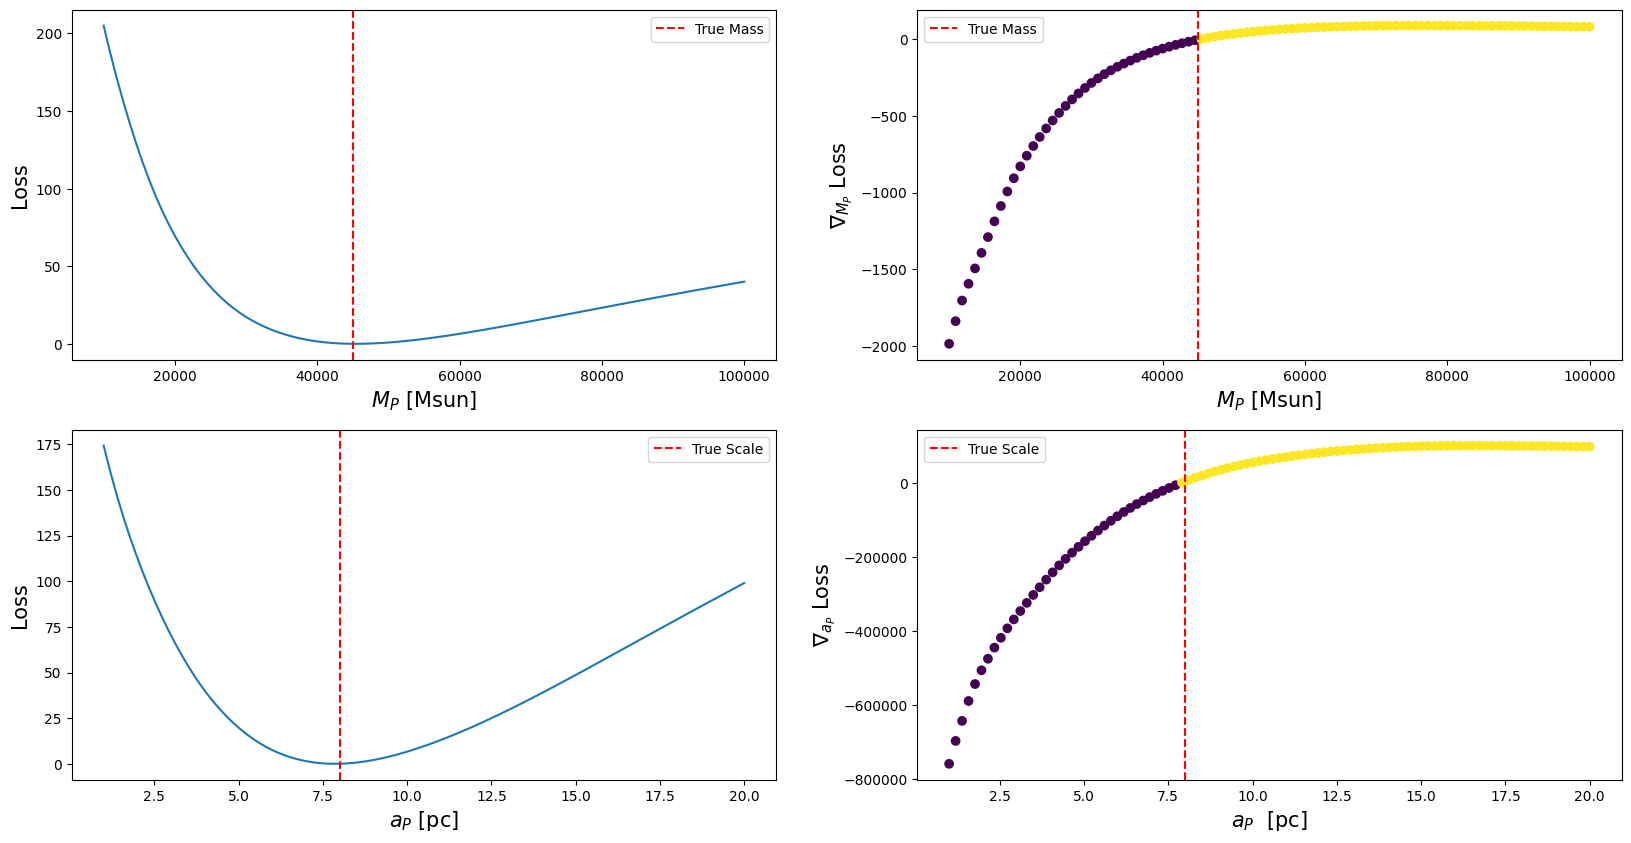

In [5]:
loss_initial_condition_mass = lambda p_mass: loss_initial_condition({'Mtot':p_mass, 'a':8.0 * u.pc.to(code_units.code_length)})
masses = jnp.linspace(1e4, 1e5, 100) * u.Msun.to(code_units.code_mass)
loss, grad = jax.vmap(jax.value_and_grad(loss_initial_condition_mass))(masses)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(221)
ax.plot(masses * code_units.code_mass.to(u.Msun), loss)
ax.axvline(4.5e4, color='r', linestyle='--', label='True Mass')
ax.legend()
ax.set_xlabel('$M_{P}$ [Msun]', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax = fig.add_subplot(222)
ax.scatter(masses * code_units.code_mass.to(u.Msun), grad, c=grad>0)
ax.axvline(4.5e4, color='r', linestyle='--', label='True Mass') 
ax.set_xlabel('$M_{P}$ [Msun]', fontsize=15)
ax.set_ylabel('$\\nabla_{M_{P}}$ Loss', fontsize=15)
ax.legend()

loss_initial_condition_scale = lambda p_scale: loss_initial_condition({'Mtot':4.5e4 * u.Msun.to(code_units.code_mass), 'a':p_scale})
scales = jnp.linspace(1.0, 20.0, 100) * u.pc.to(code_units.code_length)
loss, grad = jax.vmap(jax.value_and_grad(loss_initial_condition_scale))(scales)
ax = fig.add_subplot(223)
ax.plot(scales * code_units.code_length.to(u.pc), loss)
ax.axvline(8.0, color='r', linestyle='--', label='True Scale') 
ax.legend()
ax.set_xlabel('$a_{P}$ [pc]', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)

ax = fig.add_subplot(224)
ax.scatter(scales * code_units.code_length.to(u.pc), grad, c=grad>0)
ax.axvline(8.0, color='r', linestyle='--', label='True Scale') 
ax.legend()
ax.set_xlabel('$a_{P}$  [pc]', fontsize=15)
ax.set_ylabel('$\\nabla_{a_{P}}$ Loss', fontsize=15)


In [31]:
loss_initial_condition_joint = lambda p: loss_initial_condition({'Mtot':p[0], 'a':p[1]})
mass_grid = jnp.linspace(1e4, 1e5, 100) * u.Msun.to(code_units.code_mass)
scale_grid = jnp.linspace(1.0, 20.0, 100) * u.pc.to(code_units.code_length)
M_grid, a_grid = jnp.meshgrid(mass_grid, scale_grid, indexing='ij')
params_grid = jnp.stack([M_grid.ravel(), a_grid.ravel()], axis=1)

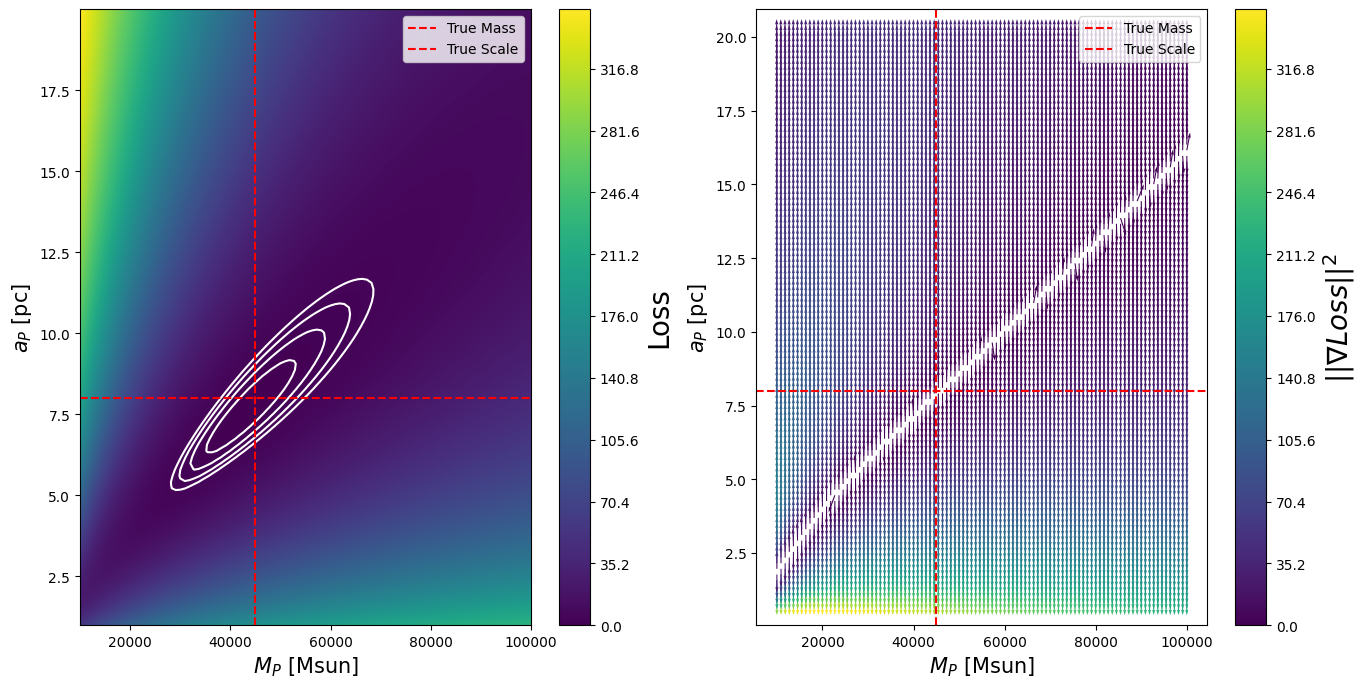

In [32]:
#LOSS
loss_grid = jax.vmap(loss_initial_condition_joint)(params_grid).reshape(M_grid.shape)
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
c = ax.contourf(M_grid * code_units.code_mass.to(u.Msun), a_grid * code_units.code_length.to(u.pc), loss_grid, levels=1000, cmap='viridis')
c2 = ax.contour(c, levels=c.levels[:10:2], colors='w')
ax.axvline(4.5e4, color='r', linestyle='--', label='True Mass') 
ax.axhline(8.0, color='r', linestyle='--', label='True Scale') 
cbar = fig.colorbar(c, ax=ax, label='Loss', )
cbar.set_label('Loss', fontsize=20)
ax.set_xlabel('$M_{P}$ [Msun]', fontsize=15)
ax.set_ylabel('$a_{P}$ [pc]', fontsize=15)
ax.legend()

#GRAD
ax = fig.add_subplot(122)
grad_loss_grid = jax.lax.map(jax.grad(loss_initial_condition_joint), xs=params_grid, batch_size=10_000).reshape(M_grid.shape + (2,))
U, V = grad_loss_grid[:,:,0], grad_loss_grid[:,:,1]
magnitude = jnp.sqrt(U**2 + V**2)
ax.quiver(M_grid * code_units.code_mass.to(u.Msun), a_grid * code_units.code_length.to(u.pc), 
          U/magnitude, V/magnitude,
          magnitude, cmap='viridis', scale=25)
cbar = fig.colorbar(c, ax=ax, label='$ ||\\nabla Loss ||^2$', )
cbar.set_label('$ ||\\nabla Loss ||^2$', fontsize=20)
ax.axvline(4.5e4, color='r', linestyle='--', label='True Mass') 
ax.axhline(8.0, color='r', linestyle='--', label='True Scale') 
ax.set_xlabel('$M_{P}$ [Msun]', fontsize=15)
ax.set_ylabel('$a_{P}$ [pc]', fontsize=15)
ax.legend()
